# CENG 483 THE 2

**Name:** Meriç Karadayı

**Student ID:** 2448553


#### Importing Libraries

In [1]:
# Import libraries
import numpy as np
import cv2 
import time
import matplotlib.pylab as plt
from scipy.signal import convolve2d

#### Constants values

In [2]:
IMG_PATH = "images"
original_names = ['chessboard.png', 'lab.png', 'tree.png']
rotated_names = ['chessboard-rotated.png', 'lab-rotated.png','tree-rotated.png']

#Weight function names
UNIFORM_W = "Uniform Weighting"
CIRCULAR_W = "Circular Weighting"
GAUSSIAN_W = "Gaussian Weighting"

#Alpha for Fast implementation
ALPHA = 0.05 

### Image functions

In [3]:
#Reading images
def read_images() -> (np.ndarray,np.ndarray):
    original_images = []
    rotated_images = []
    for img_name in original_names:
        bgr = cv2.imread(IMG_PATH + "/" + img_name)
        original_images.append(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    for img_name in rotated_names:
        bgr = cv2.imread(IMG_PATH + "/" + img_name)
        rotated_images.append(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    return np.array(original_images),np.array(rotated_images)

def display_image(images_with_corners:list,isRGB=False):
    """
    Args:
        images_with_corners (list): list of tuples which are containing images and corner coordinations -> (image,corner corrdinates). Coordinates of corners in (y,x) format.
        isRGB (bool, optional): Is the coming image RGB. Defaults to False.
    """
   
    plt.figure(figsize=(10, 5))
    
    for i in range(len(images_with_corners)):
        len(images_with_corners[i])
        image,corners = images_with_corners[i]
        plt.subplot(1,2,i+1)
        if isRGB==False:
            plt.imshow(image,cmap='gray')
        else:
            plt.imshow(image)
        for corner in corners:
            #Corner coordinates are given in (row,column)=(y,x) order, So it is reversed
            circle = plt.Circle(corner[::-1], 5, color="red", fill=False)
            plt.gca().add_patch(circle)
    plt.axis('off') 
    plt.show()

def convert_grayscale(images):
    gray_imgs=[]
    for img in images:
       gray_imgs.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) )
    return np.array(gray_imgs)

In [4]:
#Reading all images
original_images,rotated_images  = read_images()

#Creating Gray Scale images
gray_original = convert_grayscale(original_images)    
gray_rotated = convert_grayscale(rotated_images)    


# display_image(image=original_images[0], name=original_names[0])
# display_image(image=rotated_images[0],name= rotated_names[0])

# display_image(gray_original[1],name= original_names[1],isGray=True)
# display_image(gray_rotated[1], name=rotated_names[1],isGray=True)



### Filtering Functions

In [5]:
def compute_gradient(matrix,axis:str) -> np.ndarray:
    """
    Computing gradient matrix by convolving with 2D derivative filter

    Args:
        matrix (np.ndarray): Image
        axis (str): "X" or "Y" axis to compute gradient

    Returns:
        np.ndarray: Gradient matrix
    """
    if axis == "X":
        # 2D derivative filter for X axis
        filter = np.array([
            [-1/3,0,1/3],
            [-1/3,0,1/3],
            [-1/3,0,1/3],
        ])
    elif axis == "Y":
        # 2D derivative filter for Y axis
        filter = np.array([
            [1/3,1/3,1/3],
            [0,0,0],
            [-1/3,-1/3,-1/3],
        ])
    gradient_matrix = convolve2d(matrix,filter,mode="same",boundary="symm")
    return gradient_matrix

def gaussian_filter(matrix:np.ndarray)-> np.ndarray:
    """
    Applying Gaussian filter to image.

    Args:
        matrix (np.ndarray): 2D image

    Returns:
        np.ndarray: Filtered image
    """
    #Gaussian filter
    filter = np.array(
        [[1,2,1],
         [2,4,2],
         [1,2,1]]
        ) / 16
    blurred = convolve2d(matrix,filter,mode="same",boundary="symm")
    # display_image(image=blurred,isGray=True)
    return blurred

def uniform_filter(matrix:np.ndarray)->np.ndarray:
    """
    Applying Uniform Weight filter to image

    Args:
        matrix (np.ndarray): 2D image

    Returns:
        np.ndarray: Filtered image
    """
    
    #Uniform weighting filter
    filter = np.array(
        [[1,1,1],
         [1,1,1],
         [1,1,1]]
        ) / 9
    filtered = convolve2d(matrix,filter,mode="same",boundary="symm")
    # display_image(image=blurred,isGray=True)
    return filtered

def circular_filter(matrix:np.ndarray)->np.ndarray:
    """
    Applying Circular Weight filter to image

    Args:
        matrix (np.ndarray): 2D image

    Returns:
        np.ndarray: Filtered image
    """
    #Circular weighting filter
    filter = np.array(
        [[0,1,0],
         [1,1,1],
         [0,1,0]]) / 5
    filtered = convolve2d(matrix,filter,mode="same",boundary="symm")
    # display_image(image=blurred,isGray=True)
    return filtered



### Helper Functions

In [6]:
def get_corner_indexes(img):
    """
    Returns the coordinates of corners at wanted amount by sorting them from max to min.

    Args:
        img (_type_): 2D image
        count (int, optional): Corner count. Defaults to 10.

    Returns:
        two_d_ind(np.ndarray): Indices of corners first element of each sublist is row(y) index, second is column(x) index
        corner_Es(np.ndarray): Values of the chosen E's
            
    """
    count=10
    flatten_ind = np.argsort(img,axis=None,kind="mergesort")[-count::]
    two_d_ind = np.column_stack(np.unravel_index(flatten_ind, img.shape))      
    return  two_d_ind

def non_max_suppression(matrix:np.ndarray) -> np.ndarray:
    """
    Applies non maximum suppression.

    Args:
        matrix (np.ndarray): 2D matrix(image)

    Returns:
        np.ndarray: 
    """
    H,W = matrix.shape
    windows_size = 10
    #For each window, only keep the maximum value, then make the rest zero.
    for i in range(0,H-windows_size+1):
        for j in range(0,W-windows_size+1):
            window = matrix[i:i+windows_size+1,j:j+windows_size+1]
            #Getting index of max value in the window
            max_index = np.argmax(window)
            #Converting index wrt to window shape
            max_coordinates = np.unravel_index(max_index, window.shape)
            #Store value of the max
            mx = window[max_coordinates[0],max_coordinates[1]]
            #Make all elements zero
            window[:,:] = 0
            #Assign the max value back
            window[max_coordinates[0],max_coordinates[1]] = mx
    return matrix

## Naive Formula + Uniform Weighting (without Non-Maximum Suppression)

$$
E(u,v) = \sum_{(x,y) \in W} [I(x+u,y+u) - I(x,y)]^{2}
$$


In [7]:
def NaiveFormula(image:np.ndarray,shift_size:int,window_size:int,applyNonMaxSuppression:bool):
    """
    Applies Naive formula above to the image

    Args:
        image (np.ndarray): 2D image - Gray Scale
        shift_size (int): Shifting amount
        window_size (int): Window size -> Windows (window_size,window_size)
        applyNonMaxSuppression (bool): If non max suppression is needed
    """
    shift_pairs=[ #(u,v)
        (0,-shift_size),
        (shift_size,-shift_size),
        (shift_size,0),
        (shift_size,shift_size),
        (0,shift_size),
        (-shift_size,shift_size),
        (-shift_size,0),
        (-shift_size,-shift_size)
    ]
    H,W= image.shape
    E = np.zeros((H,W))
    
    half_windows_size = window_size//2
    window = np.zeros((window_size,window_size))
    
    #Ranges for the loops
    i_start = half_windows_size
    i_end = H - half_windows_size
    
    j_start = half_windows_size
    j_end = W - half_windows_size
    for i in range(i_start,i_end):
        for j in range(j_start,j_end):
            E_ij_list=[]
            window = image[i-half_windows_size:i+half_windows_size+1,j-half_windows_size:j+half_windows_size+1]
            for u,v in shift_pairs:
                #If the current window is fully inside of image sizes -> (0,H) and (0,W)
                if (i-half_windows_size+u) < 0 or (i+half_windows_size+u+1) > H or (j-half_windows_size+v) < 0 or (j+half_windows_size+v+1) > W:
                    continue
                shifted_window = image[i-half_windows_size+u:i+half_windows_size+u+1,j-half_windows_size+v:j+half_windows_size+v+1]
                E_ij_list += [np.sum(np.square(shifted_window - window))]
            # Keep the minimum change amount of the windows
            E[i,j] = min(E_ij_list)    
    if applyNonMaxSuppression:
        E = non_max_suppression(matrix=E)
    corner_indices = get_corner_indexes(E)
    return corner_indices
    

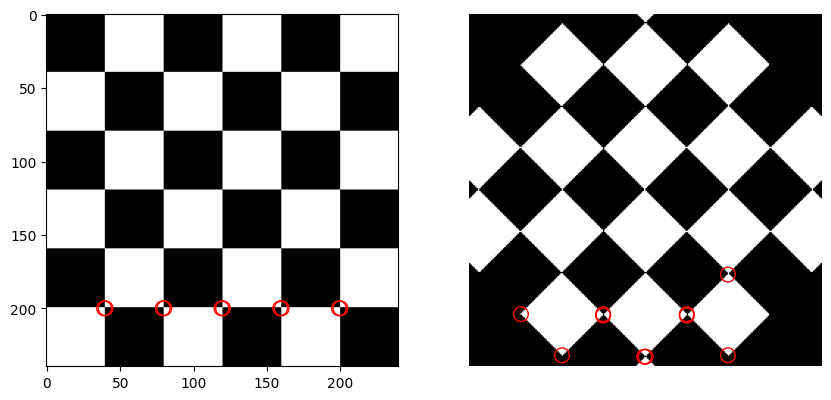

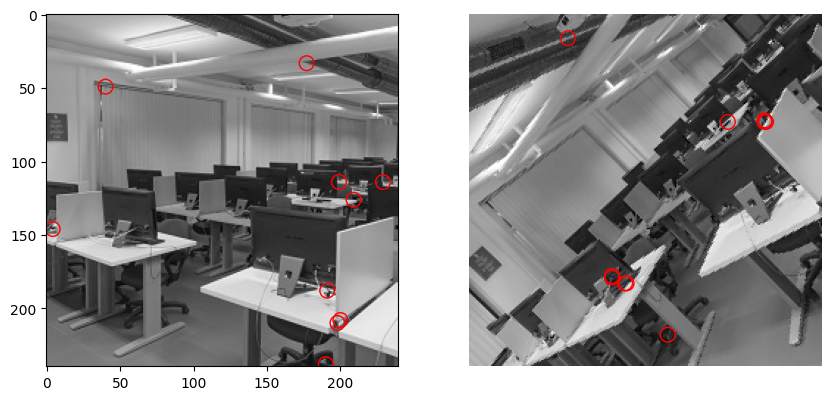

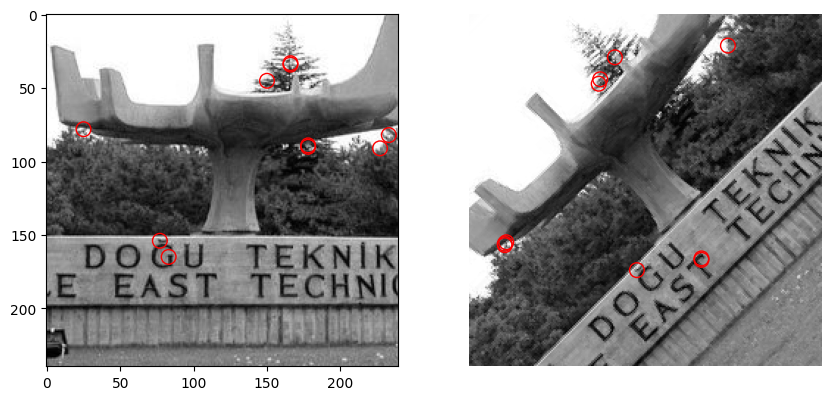

Average time per image: 3.831496834754944


In [8]:
img_cnt = original_images.shape[0]
start_time = time.time()
for i in range(img_cnt):
    img_corners=[]
    corner_indices_orig = NaiveFormula(image=gray_original[i],shift_size=1,window_size=3,applyNonMaxSuppression=False)
    img_corners += [(gray_original[i],corner_indices_orig)]
    corner_indices_rotated = NaiveFormula(image=gray_rotated[i],shift_size=1,window_size=3,applyNonMaxSuppression=False)
    img_corners += [(gray_rotated[i],corner_indices_rotated)]
    display_image(images_with_corners=img_corners,isRGB=False)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Average time per image: {elapsed_time/(2*img_cnt)}")

**Time**

When we compare Naive Formula with other methods, we can observe that it is running significantly slower as expected. I belive the main reason for this difference is that we are calculating the an additional shifted window for each shift direction. Also to compute the E for each shift, we are calculating square of the difference between the windows which can be a possible time consuming process. 

**Absence of non maximumum suppression**

For this experience, I have used a uniform weighting without applying non maximum suppression to E values. This is leading overlapping corners on detections. This situation can also seen on the output images. For example, we can only see 5 detected corners on chessboard.png. However, It supposed to find 10 corners. It is visible that circles are thicker than they should be and those are the overlapped detections. This is not a desired output, since algorithm is finding 10 corners, there are actually 5 distinct corners. The reason of this is that when there is a sharp intensity change between pixel windows, effect of this high E value does not appear in results of only 1 pixel. Also the near pixels are effected from this sharp change, so their calculated E values are also high due to same intensity change and we calling this high intensity changes corner. Therefore, the absence of non maximum suppression is causing detection of same corner on different pixels as they are different corner. I believe, we should apply non maximum suppression to get better results.

**Effect of Rotation**

The detected corners on original and rotated images are mostly different from each other even there exist some same detected points.

**General Output**

If we ignore those problems, and just focus on the corners that are found, the detected points are mostly corners of objects. Even if it is not a corner, it has intensity difference between near pixels.

## Naive Formula + Uniform Weighting

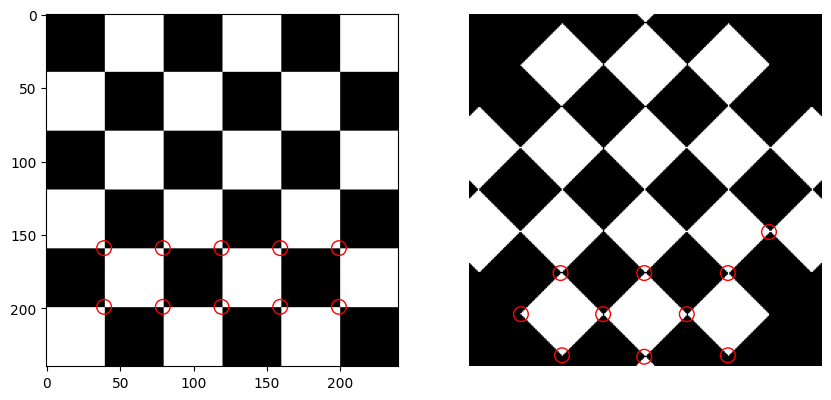

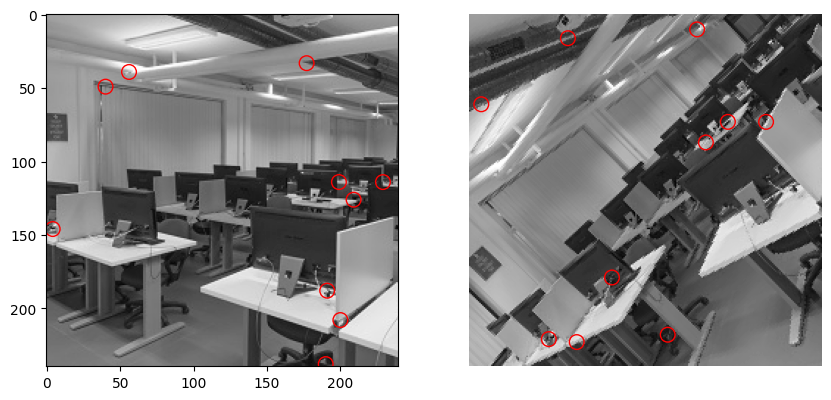

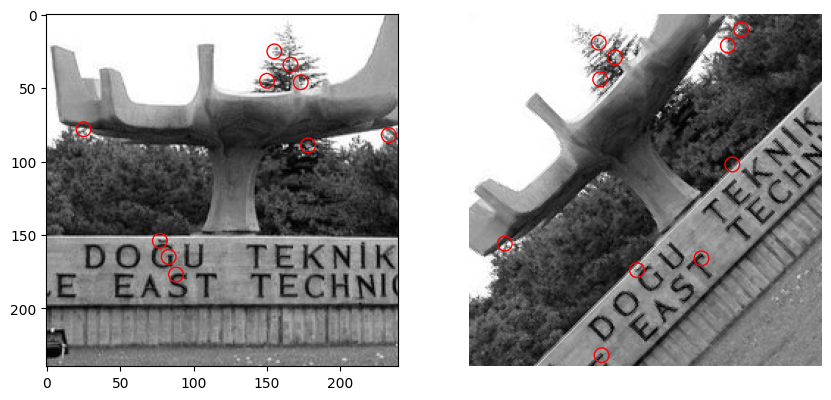

Average time per image: 3.934682091077169


In [9]:
img_cnt = original_images.shape[0]
start_time = time.time()
for i in range(img_cnt):
    img_corners=[]
    corner_indices_orig = NaiveFormula(image=gray_original[i],shift_size=1,window_size=3,applyNonMaxSuppression=True)
    img_corners += [(gray_original[i],corner_indices_orig)]
    corner_indices_rotated = NaiveFormula(image=gray_rotated[i],shift_size=1,window_size=3,applyNonMaxSuppression=True)
    img_corners += [(gray_rotated[i],corner_indices_rotated)]
    display_image(images_with_corners=img_corners,isRGB=False)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Average time per image: {elapsed_time/(2*img_cnt)}")


**Time**

When time of 2 different versions of Naive is compared. There is not any significance difference. Use of non maximum suppression is increasing time consumption by approximately 0.5 seconds.

**Effect of non maximumum suppression**

When results of Naive Formula with and without non maximum suppression are compared, now we do not detect same corners anymore. Applying a such function has solved this problem. By doing this process, beside getting rid of same corners, it also provided us to ability to detect more corners since our corner count is limited to top 10 at this experiment.

At implementation phase of non maximum suppression, I have chosen window to find the max value as 10x10. Firstly, I have tried to make it 3x3, but there were still detected corners which are so close to each other which were result of same corner. Then, I decided to expand my window size to 10x10. I think ,this problem is solved by such adjustment.

**General Output**

In my opinion use of non-max suppression is an essential step for finding corners even the small time difference. The result are more robust now.

## Taylor's Approximation + Uniform Weighting

$$
E(u,v) = 
\sum_{(x,y) \in W} 
\begin{bmatrix}
  u & v \\
\end{bmatrix}
\begin{bmatrix}
  I_{x}^{2} &  I_{x}I_{y} \\
  I_{x}I_{y} &  I_{y}^{2} \\
\end{bmatrix}
\begin{bmatrix}
  u \\
  v \\
\end{bmatrix}
$$




In [10]:
def TaylorsApprox(image:np.ndarray,shift_size,window_size:int):
    """
    Applies Taylor Approximation formula above to the image

    Args:
        image (np.ndarray): 2D image - Gray Scale
        shift_size (int): Shifting amount
        window_size (int): Window size -> Windows (window_size,window_size)
        
    """
    H,W = image.shape
    
    #Compute gradient vectors for both axis
    I_x = compute_gradient(matrix=image,axis="X")
    I_y = compute_gradient(matrix=image,axis="Y")
    #Calculating the multiplication of gradients for the formula
    I_xx = np.multiply(I_x,I_x)
    I_xy = np.multiply(I_x,I_y)
    I_yy = np.multiply(I_y,I_y)
    
    shift_pairs=[ #(u,v)
        (0,-shift_size),
        (shift_size,-shift_size),
        (shift_size,0),
        (shift_size,shift_size),
        (0,shift_size),
        (-shift_size,shift_size),
        (-shift_size,0),
        (-shift_size,-shift_size)
    ]
    E = np.zeros((H,W))
    
    half_windows_size = window_size//2
    
    #Loop ranges
    i_start = half_windows_size
    i_end = H - half_windows_size
    j_start = half_windows_size
    j_end = W - half_windows_size
    for i in range(i_start,i_end):
        for j in range(j_start,j_end):
            #Summ of the gradient vectors for the window
            sum_I_xx = np.sum(I_xx[i-half_windows_size:i+half_windows_size+1,j-half_windows_size:j+half_windows_size+1])
            sum_I_xy = np.sum(I_xy[i-half_windows_size:i+half_windows_size+1,j-half_windows_size:j+half_windows_size+1])
            sum_I_yy = np.sum(I_yy[i-half_windows_size:i+half_windows_size+1,j-half_windows_size:j+half_windows_size+1])
            
            E_ij_list = []
            
            #Calculation E for each shift
            for u,v in shift_pairs: 
                E_ij_list += [ np.abs(u**2 * sum_I_xx + 2 * u*v*sum_I_xy + v**2 * sum_I_yy)]
            #Keeping the minimum E
            E[i,j] = min(E_ij_list)
    E = non_max_suppression(matrix=E)
    corner_indices = get_corner_indexes(E)
    return corner_indices
    


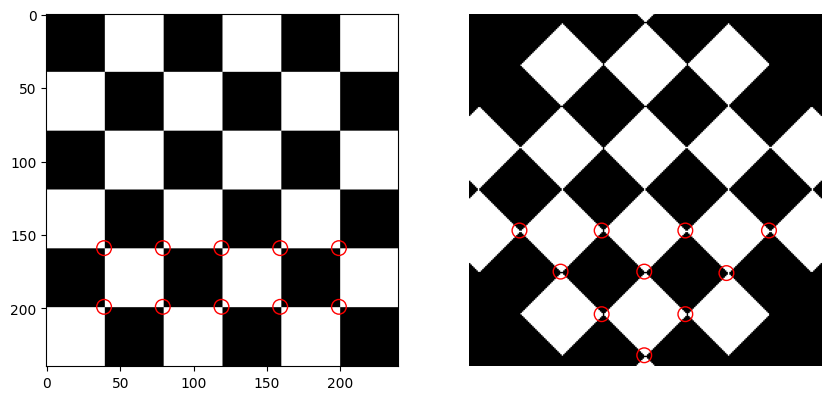

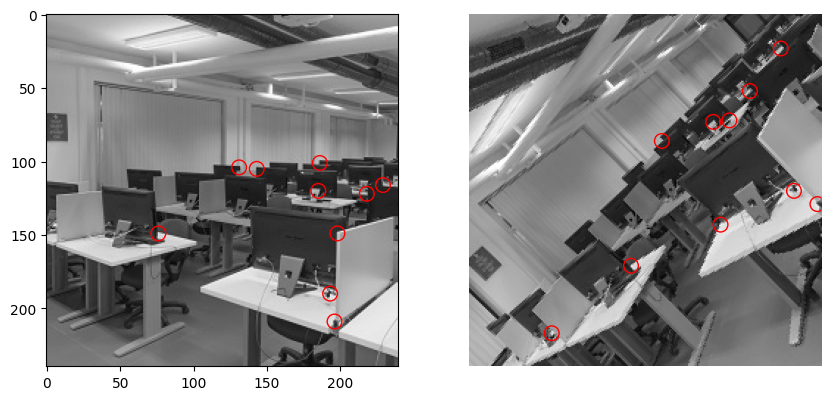

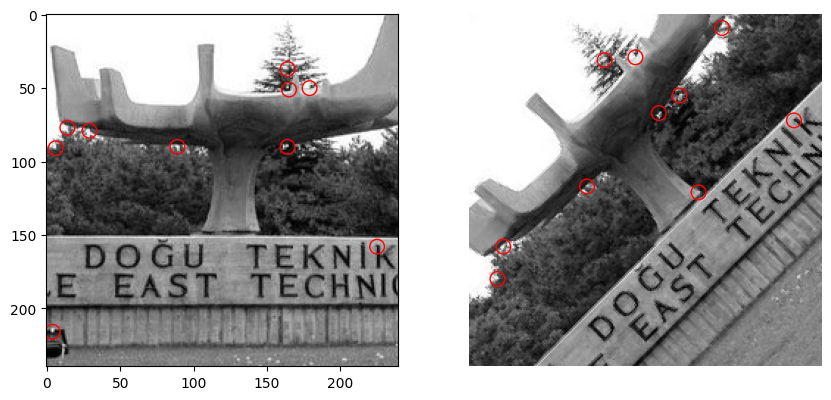

Average time per image: 1.8299680948257446


In [11]:
img_cnt = original_images.shape[0]
start_time = time.time()
for i in range(img_cnt):
    img_corners=[]
    corner_indices_orig = TaylorsApprox(image=gray_original[i],shift_size=1,window_size=3)
    img_corners += [(gray_original[i],corner_indices_orig)]
    corner_indices_rotated = TaylorsApprox(image=gray_rotated[i],shift_size=1,window_size=3)
    img_corners += [(gray_rotated[i],corner_indices_rotated)]
    display_image(images_with_corners=img_corners,isRGB=False)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Average time per image: {elapsed_time/(2*img_cnt)}")

When we compare the formula between Naive and Taylor method. The main difference is that in Naive we were taking difference on all directions but in Taylor we are only using X, Y axis changes and assuming diagonal changes as composition of these 2. Therefore, I think, this could lead some minor output changes.

**Time**

By using Taylor Approximation formula, average time per image is reduced from 3.5-4 second to 1.5 second when compared with the Naive. Calculating the Ix and Iy gradient matrices one time and using it for windows shift difference made a huge improvement on time aspect.


**Effect of Rotation**

Initially, I thought that rotation should change the outputs more than the Naive Formula changes. Because we are considering the differences of pixels with only up, bottom, right, left pixels and we are changing whole of those neighbor pixels by rotating. However when I examine the output images this was not as I expected. I observed that Taylor is more rotation invariant than Naive. I believe that the reason of this is that using less information(using 4 directly intensity difference instead of 8) is behaving like some kind of smoothing operation. Therefore the detected corners are being effected by rotation less.

**General Output**

This approach is way faster than Naive formula and I think, the results are more robust than the Naive.

## Fast Implementation + Uniform Weighting

$$
M = 
\sum_{x,y} 
w(x,y)
\begin{bmatrix}
  I_{x}^{2} &  I_{x}I_{y} \\
  I_{x}I_{y} &  I_{y}^{2} \\
\end{bmatrix}
$$

$$
\theta = det(M) - \alpha trace(M)^{2}
$$



In [12]:
def FastImplemantation(image:np.ndarray,window_size:int, weight_func:str, isRGB=False):
    """
    Applies Fast Implementation formula above to the image

    Args:
        image (np.ndarray): 2D image - Gray Scale or RGB
        window_size (int): Window size -> Windows (window_size,window_size)
        weight_func (str): {GAUSSIAN_W, UNIFORM_W, CIRCULAR_W},
        isRGB (bool, optional): Is image RGB format, is image 3D. Defaults to False(Gray).
    """
    H = image.shape[0]
    W = image.shape[1]
    C_lst = []
    if isRGB:
        C_lst += [image[:,:,0]]
        C_lst += [image[:,:,1]]
        C_lst += [image[:,:,2]]  
    else:
        C_lst += [image]
    E = np.ones((H,W)) * -1
    # E = np.zeros((H,W))
    
    C = len(C_lst)
    #For each channel of the image
    for c in range(C): #If RGB C = 3, if Gray C = 1
        
        #Calculating gradient matrices and their multiplications for the formula
        I_x = compute_gradient(C_lst[c],"X")
        I_y = compute_gradient(C_lst[c],"Y")
        I_xx = np.multiply(I_x,I_x)
        I_xy = np.multiply(I_x,I_y)
        I_yy = np.multiply(I_y,I_y)
        
        #Applying the provided filter
        if weight_func == UNIFORM_W:
            I_xx_filtered = uniform_filter(I_xx)
            I_xy_filtered = uniform_filter(I_xy)
            I_yy_filtered = uniform_filter(I_yy)
        elif weight_func == CIRCULAR_W:
            I_xx_filtered = circular_filter(I_xx)
            I_xy_filtered = circular_filter(I_xy)
            I_yy_filtered = circular_filter(I_yy)
        elif weight_func == GAUSSIAN_W:
            I_xx_filtered = gaussian_filter(I_xx)
            I_xy_filtered = gaussian_filter(I_xy)
            I_yy_filtered = gaussian_filter(I_yy)
            
        #Calculating theta/E 
        det = I_xx_filtered * I_yy_filtered - I_xy_filtered**2
        trace = I_xx_filtered+ I_yy_filtered
        theta = det - ALPHA* trace**2   
        E = np.maximum(E,theta)
        # E = np.sum(E,theta)
         
    E = non_max_suppression(matrix=E)
    corner_indices = get_corner_indexes(E)
    return corner_indices      

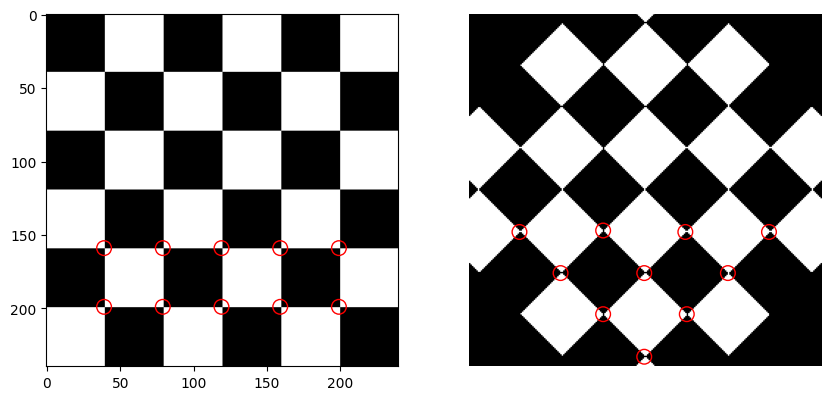

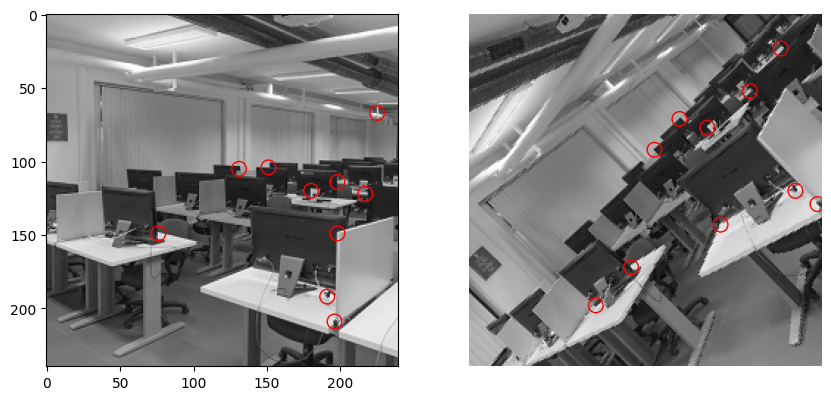

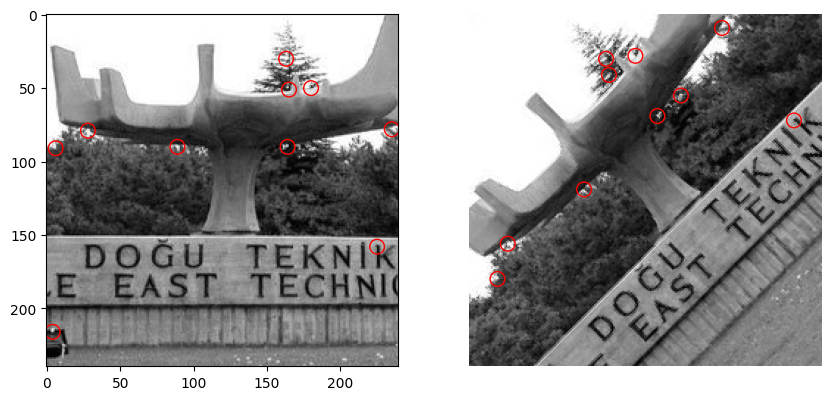

Average time per image: 0.4784453312555949


In [13]:
img_cnt = original_images.shape[0]
start_time = time.time()
for i in range(img_cnt):
    img_corners=[]
    corner_indices_orig = FastImplemantation(image=gray_original[i],window_size=3,weight_func=UNIFORM_W)
    img_corners += [(gray_original[i],corner_indices_orig)]
    corner_indices_rotated = FastImplemantation(image=gray_rotated[i],window_size=3,weight_func=UNIFORM_W)
    img_corners += [(gray_rotated[i],corner_indices_rotated)]
    display_image(images_with_corners=img_corners,isRGB=False)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Average time per image: {elapsed_time/(2*img_cnt)}")

The results are so similar with the Taylor approximation except the average time per image.

**Time**

Even Taylor Approximation increased the calculating speed of our Harris algorithm, Fast Implementation made a significant decrease in run time. It has dropped to less then 1 second for each. I think this is due to we are not calculating sum of the gradient matrices for each pixel anymore and also we are not using u,v anymore. Since they were being processed in loops repeatedly, the removal of those has improved our complexity.

## Fast Implementation + Circular Weighting

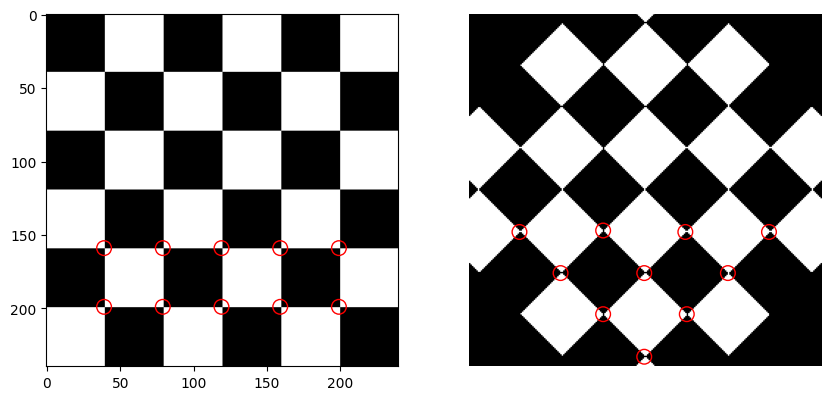

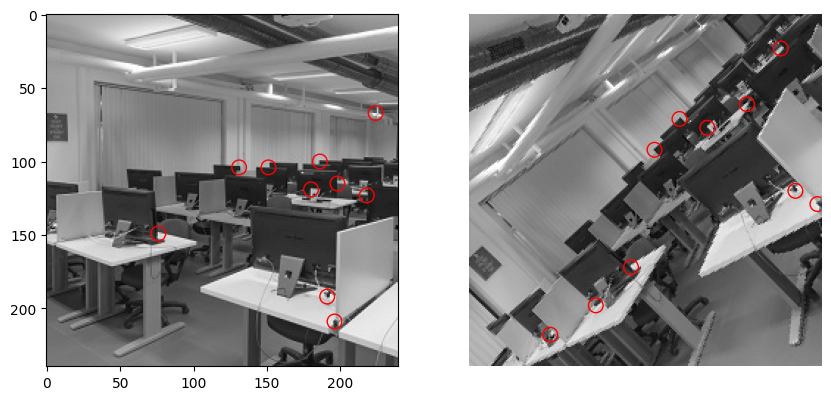

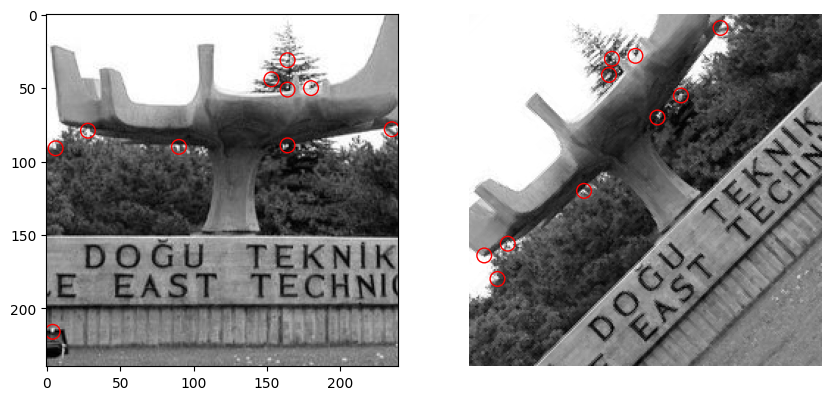

Average time per image: 0.456348975499471


In [14]:
img_cnt = original_images.shape[0]
start_time = time.time()
for i in range(img_cnt):
    img_corners=[]
    corner_indices_orig = FastImplemantation(image=gray_original[i],window_size=3,weight_func=CIRCULAR_W)
    img_corners += [(gray_original[i],corner_indices_orig)]
    corner_indices_rotated = FastImplemantation(image=gray_rotated[i],window_size=3,weight_func=CIRCULAR_W)
    img_corners += [(gray_rotated[i],corner_indices_rotated)]
    display_image(images_with_corners=img_corners,isRGB=False)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Average time per image: {elapsed_time/(2*img_cnt)}")

By applying Circular Weighting to our matrices, we are smoothing our image as uniform weighting but we are discarding the cross neighbor pixel's effect to the pixels. By doing this, importance of the central pixels are being boosted. After applying this window filter, top-10 corners are mostly same with the corners of Fast Implementation + Uniform. Also the time per image is not changing. As a result, use of these 2 filters does not make an obvious change on this inputs.

## Fast Implementation + Gaussian Weighting

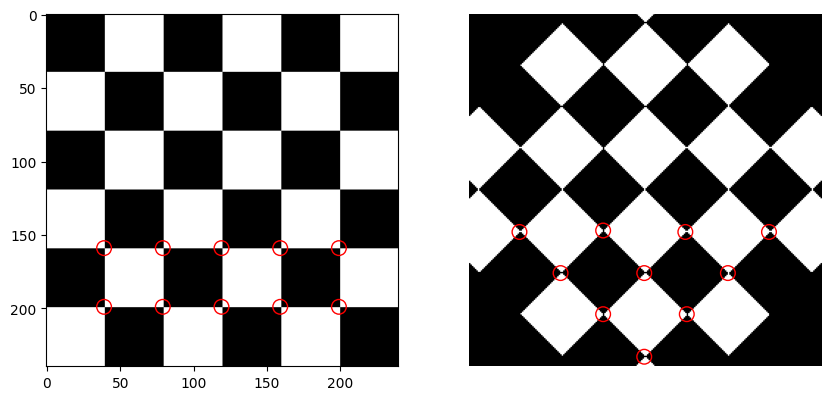

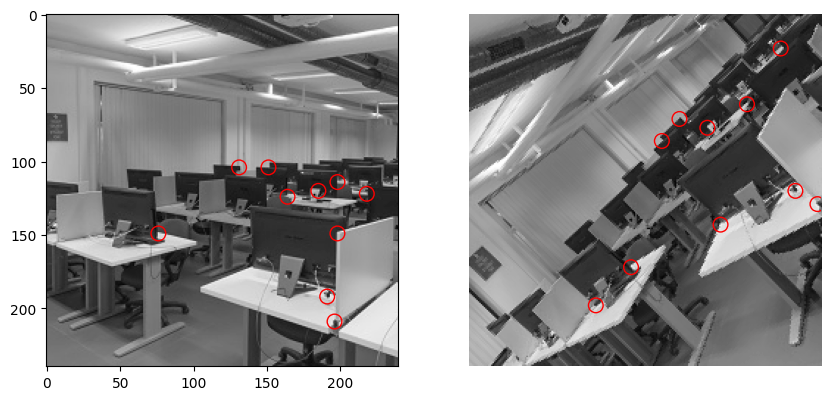

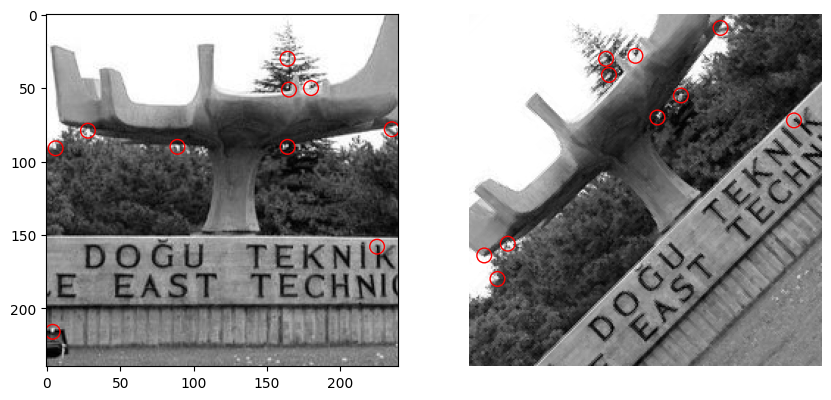

Average time per image: 0.49117545286814374


In [15]:
img_cnt = original_images.shape[0]
start_time = time.time()
for i in range(img_cnt):
    img_corners=[]
    corner_indices_orig = FastImplemantation(image=gray_original[i],window_size=3,weight_func=GAUSSIAN_W)
    img_corners += [(gray_original[i],corner_indices_orig)]
    corner_indices_rotated = FastImplemantation(image=gray_rotated[i],window_size=3,weight_func=GAUSSIAN_W)
    img_corners += [(gray_rotated[i],corner_indices_rotated)]
    display_image(images_with_corners=img_corners,isRGB=False)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Average time per image: {elapsed_time/(2*img_cnt)}")

I think that, use of Gaussian Weighting is like reinforced version of Circular weighting on centers, since the intermediate values on filter has higher values. Shortly, it is increasing importance of the main pixel than neighbour pixels during smoothing. While detecting corners, one of the main goals is finding an exact single point, so increasing the weight of the central pixels is helping us in such way. 

## Fast Implementation + Gaussian Weighting + RGB Split

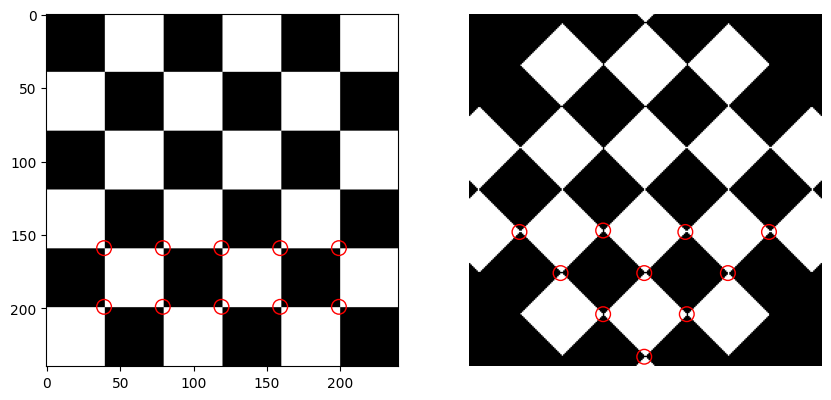

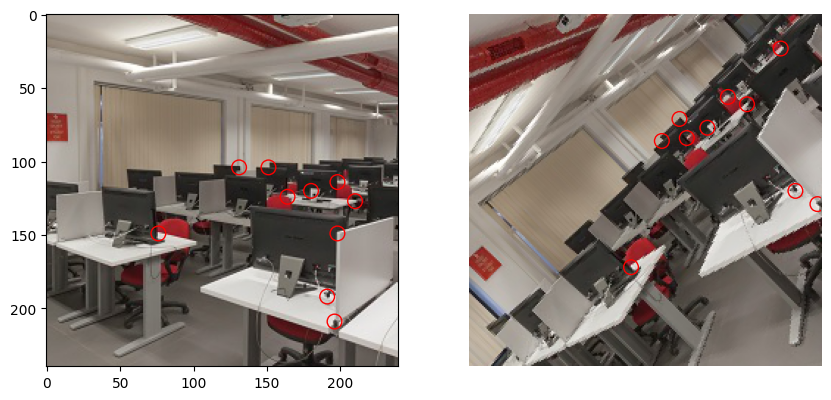

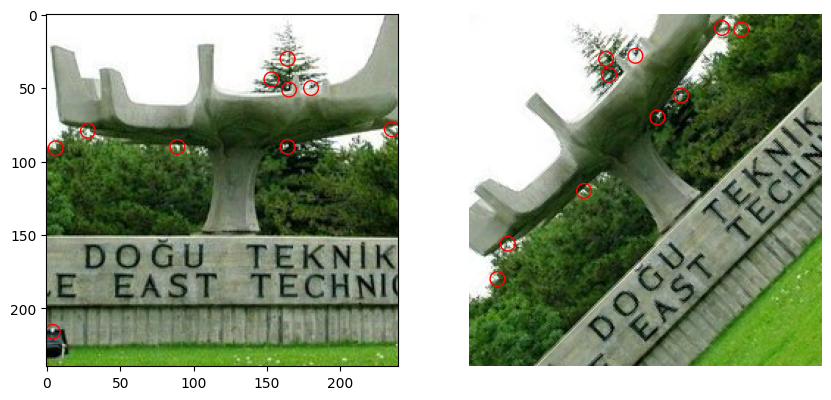

Average time per image: 0.48399726549784344


In [16]:
img_cnt = original_images.shape[0]
start_time = time.time()
for i in range(img_cnt):
    img_corners=[]
    corner_indices_orig = FastImplemantation(image=original_images[i],window_size=3,weight_func=GAUSSIAN_W,isRGB=True)
    img_corners += [(original_images[i],corner_indices_orig)]
    corner_indices_rotated = FastImplemantation(image=rotated_images[i],window_size=3,weight_func=GAUSSIAN_W,isRGB=True)
    img_corners += [(rotated_images[i],corner_indices_rotated)]
    display_image(images_with_corners=img_corners,isRGB=True)
    

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Average time per image: {elapsed_time/(2*img_cnt)}")


Firstly, I want to describe my aproach to this part for using RGB channels. I have calculated intensity differences for each channel seperately as homework pdf states. For combining the scores of different channels, I initially thought to sum the RGB channels for each pixel and use that score for corner detection and implement my function with this approach. Because total intensity difference should represent the color values more than single channel differences. Single channel intensity difference only be a result of a tone change, however if all of the 3 channels are different than neighbors, probably the pixels belong to different objects/textures. Later, I realized that summing all channels approach is a similar proccess as converting to gray scale, since it is also a weighted average of RGB channels. And in homeworks, we are trying to experience the effects of using different concepts on same goal. Therefore, I decided to get maximum single channel RGB scores for each channel. 

However, adding new channels for consideration did not result in different outputs than Gray Scale results.

# Conclusion

After various trials of different, I think Fast Implementation + Gaussian Weighting with gray scale is the best method. When Fast implementation is compared with the Naive and Taylor, there is a huge performance difference. Also there is not a obvious trade-off comming from this performance boost. Therefore for the main formula/implementation Fast is the best choice. 

When the choice of weight filter is considered, I think there is not a visible difference between in our experiments between the filter types unlike the formulas. However, in my opinion, conceptually use of Gaussian Weighting is making much more sense, because we want find one detected point that representing the corner. In uniform all pixels in the window have the same effect to the score and in circular again all pixels except the corner pixels in the windows have the same effect. But Gaussian is giving heavier weights to central pixels at windows and this provide corner points to have higher score than the near pixels.

Lastly, I did not wanted to inculde RGB splitting method. The reason is that I think using RGB channel scores seperately can mislead the scores. For example, a pixel has scores as $E_{R} = 200$, $E_{G} = 0$, $E_{B} = 0$, and another pixel has scores as $E_{R} = 199$, $E_{G} = 199$, $E_{B} = 199$. RGB splitting method will choose first point since it has the maximum value but the the second pixel can have a higher probability to be the corner. 